# Data augmentation

Data augmentation is a straighforward way to artificially increase the size
of the dataset by applying transformations to the data. It is very useful
when the dataset is small, or to reduce overfitting in large models.
But not all transformations are applicable. For example, for image
recognition it may not matter if the image is rotated, flipped or stretched.
On the other hand, flipping and rotating may not be a good idea for
handwriting recognition (e.g. a "p" gets turned into a "q" or "b", a "6" into
a "9"). The key is to find *invariances* of the *learning task*.

## Setup

In [1]:
import os
import json
import numpy as np
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics
from tqdm.auto import tqdm
import utils  # helper functions -- check out utils.py

# For reproducibility
np.random.seed(42)


## Load dataset 

In [2]:

DATASET_PATH = 'dataset/'  # path to your extracted windows
X_FEATS_PATH = 'X_feats.pkl'  # path to your extracted features
print(f'Content of {DATASET_PATH}')
print(os.listdir(DATASET_PATH))

with open(DATASET_PATH+'info.json', 'r') as f:
    info = json.load(f)  # load metadata

X = np.memmap(DATASET_PATH+'X.dat', mode='r', dtype=info['X_dtype'], shape=tuple(info['X_shape']))
Y = np.memmap(DATASET_PATH+'Y.dat', mode='r', dtype=info['Y_dtype'], shape=tuple(info['Y_shape']))
T = np.memmap(DATASET_PATH+'T.dat', mode='r', dtype=info['T_dtype'], shape=tuple(info['T_shape']))
P = np.memmap(DATASET_PATH+'P.dat', mode='r', dtype=info['P_dtype'], shape=tuple(info['P_shape']))
X_feats = pd.read_pickle('X_feats.pkl')

print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('T shape:', T.shape)
print('P shape:', P.shape)
print('X_feats shape:', X_feats.shape)


Content of dataset/
['Y.dat', 'info.json', 'P.dat', 'T.dat', 'X.dat']
X shape: (294309, 3000, 3)
Y shape: (294309,)
T shape: (294309,)
P shape: (294309,)
X_feats shape: (294309, 22)


## Train/test split

In [3]:

# Take out 10 participants
test_ids = ['002', '003', '004', '005', '006', 
            '007', '008', '009', '010', '011']
mask_test = np.isin(P, test_ids)
mask_train = ~mask_test
X_train, Y_train, P_train, T_train = \
    X_feats[mask_train], Y[mask_train], P[mask_train], T[mask_train]
X_test, Y_test, P_test, T_test = \
    X_feats[mask_test], Y[mask_test], P[mask_test], T[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (274462, 22)
Shape of X_test: (19847, 22)


## Train a random forest classifier

*Note: this may take a while*

In [4]:
clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    replacement=True,
    sampling_strategy='not minority',
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf.fit(X_train, Y_train)

Y_test_pred = clf.predict(X_test)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred, zero_division=0)) 


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   53.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 2000 

## Robustness to unforseen scenarios

What if the subjects in the test set wore the device differently from
those in the training set? For example, suppose that all the subjects in the
training set were right-handed, but the test subjects are left-handed.
This would more or less result in the device being rotated.

<img src="wrist_accelerometer.jpg" width="200"/>

Let's generate an artificial test set simulating this scenario by flipping
two of the axes signs (it does not exactly simulate a rotation since the
movement dynamics are also mirrored, but it is enough for our demonstration
purposes).

In [5]:
# Split raw data into train and test set
# X[mask_train] and X[mask_test] if you like to live dangerously
X_raw_train = utils.ArrayFromMask(X, mask_train)
X_raw_test = utils.ArrayFromMask(X, mask_test)

print("Creating test set with 'rotated device'...")
X_rot_test = []
for i in tqdm(range(X_raw_test.shape[0])):
    # Rotate device
    x = X_raw_test[i].copy()
    x[:,1] *= -1
    x[:,2] *= -1
    X_rot_test.append(utils.extract_features(x))
X_rot_test = pd.DataFrame(X_rot_test)



Creating test set with 'rotated device'...


In [6]:
''' ### Performance on simulated test set '''



' ### Performance on simulated test set '

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    2.5s finished

Classifier performance -- simulated test set
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.59      0.71      0.64       347
       mixed       0.47      0.35      0.40      1955
   sit-stand       0.87      0.75      0.81      8523
       sleep       0.93      0.92      0.92      7500
     vehicle       0.23      0.54      0.33       609
     walking       0.29      0.57      0.39       913

    accuracy                          

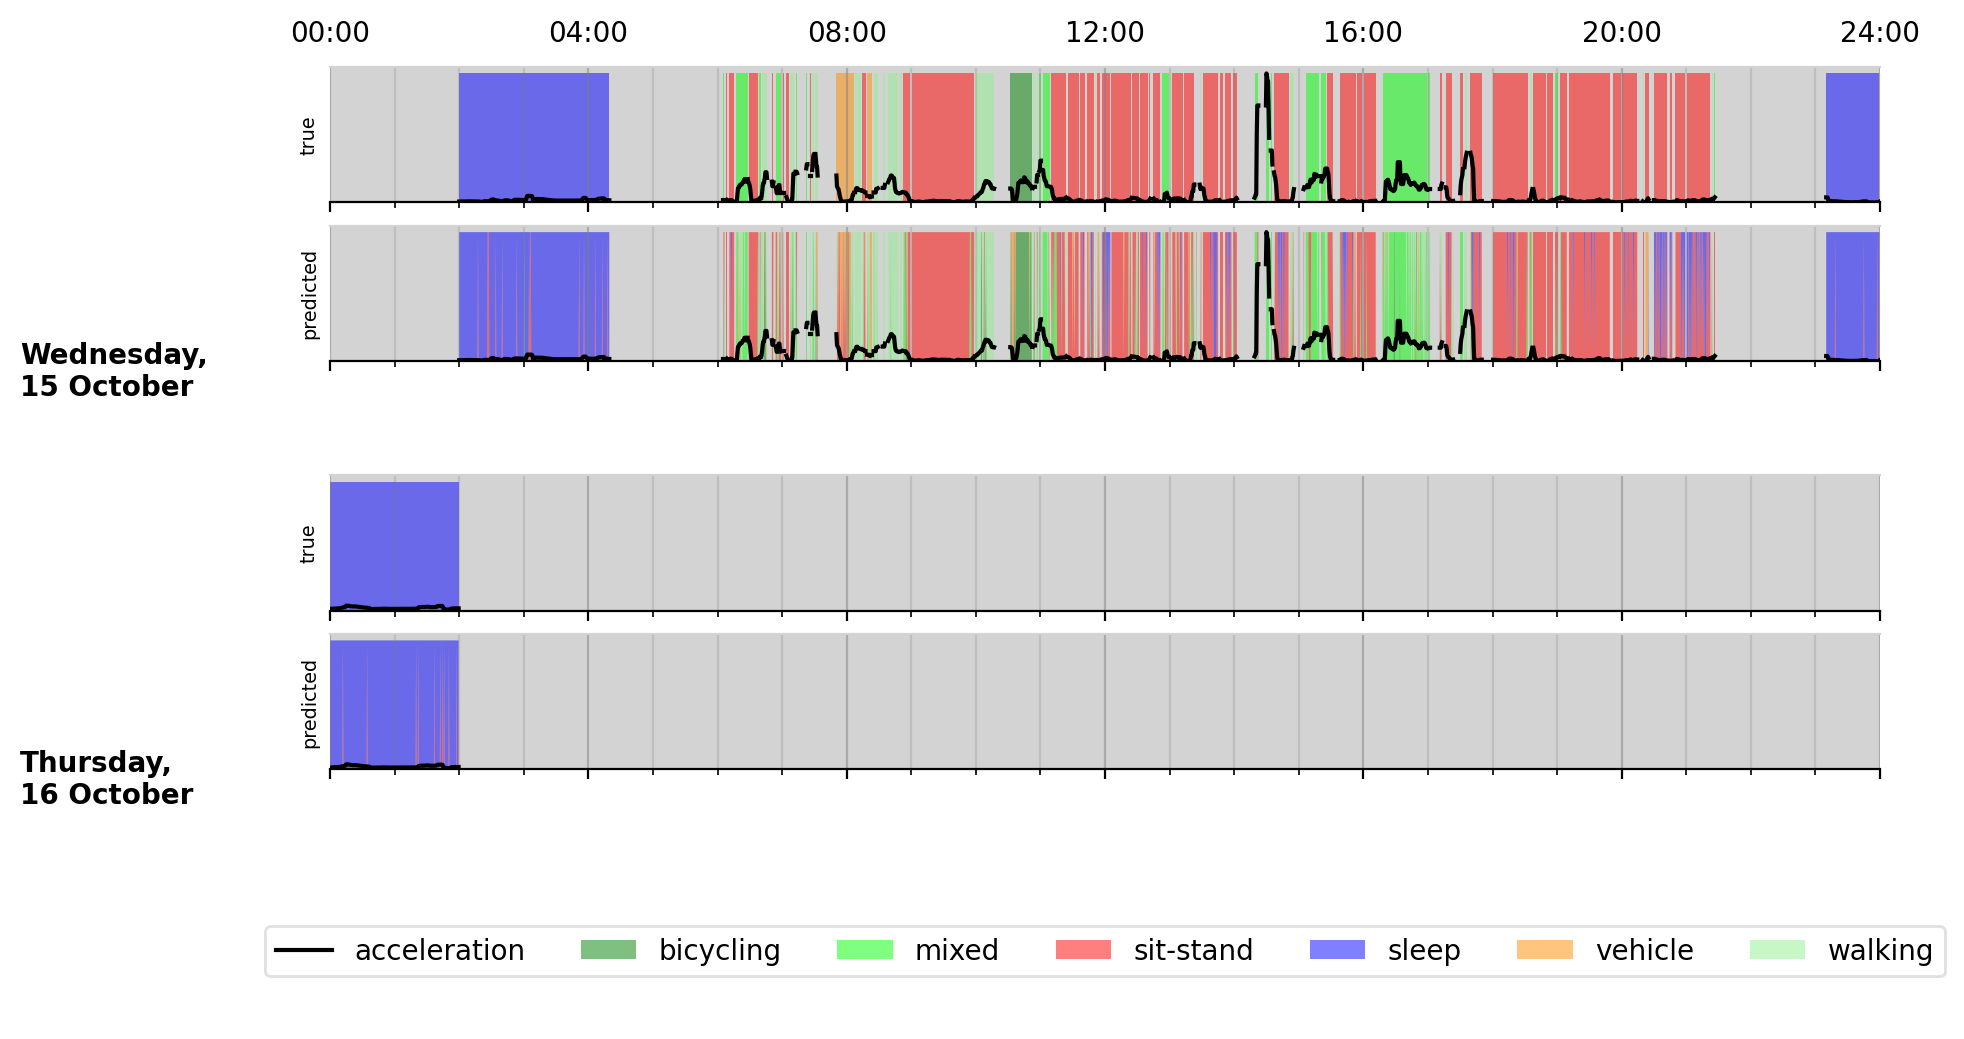

In [7]:

X_rot_test = pd.DataFrame(X_rot_test)

Y_rot_test_pred = clf.predict(X_rot_test)
print('\nClassifier performance -- simulated test set')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_rot_test_pred, zero_division=0)) 

# let's plot participant 006
mask = P_test=='006'
utils.plot_compare_activity(T_test[mask], 
                      Y_test[mask],
                      Y_rot_test_pred[mask], 
                      X_test.loc[mask, 'mean'])



In [8]:
'''
The model performance is notably worse on the simulated set. The solution is
simply to augment the training dataset with the rotation &mdash; in
general, with transformations that we wish our model to be invariant to. In
our case, we wish our model to perform well no matter how the device was
worn.

## Data augmentation

'''



'\nThe model performance is notably worse on the simulated set. The solution is\nsimply to augment the training dataset with the rotation &mdash; in\ngeneral, with transformations that we wish our model to be invariant to. In\nour case, we wish our model to perform well no matter how the device was\nworn.\n\n## Data augmentation\n\n'

In [9]:
print("Creating training set with 'rotated device'...")
X_rot_train = []
for i in tqdm(range(X_raw_train.shape[0])):
    # Rotate device
    x = X_raw_train[i].copy()
    x[:,1] *= -1
    x[:,2] *= -1
    X_rot_train.append(utils.extract_features(x))
X_rot_train = pd.DataFrame(X_rot_train)

# Add the "new data" to training set
X_aug_train = pd.concat((X_train, X_rot_train))
Y_aug_train = np.concatenate((Y_train, Y_train))
print("X_aug_train shape:", X_aug_train.shape)



Creating training set with 'rotated device'...



X_aug_train shape: (548924, 22)


In [10]:
''' ### Re-train and check performance

*Note: this may take a while
'''



' ### Re-train and check performance\n\n*Note: this may take a while\n'

In [11]:
clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    replacement=True,
    sampling_strategy='not minority',
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf.fit(X_aug_train, Y_aug_train)

Y_rot_test_pred = clf.predict(X_rot_test)
print('\nClassifier performance -- augmented model on simulated test set')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_rot_test_pred, zero_division=0)) 



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   50.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 2000 

In [12]:
'''
Some of the performance is recovered with the augmented model.
'''


'\nSome of the performance is recovered with the augmented model.\n'